# Random forest classifier

## Preamble


We load the required packages, we read the data, we apply our feature engineering routine, we apply the train-test split and we oversample the train set. 

### Packages

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import optuna
from imblearn.over_sampling import SMOTENC


In [2]:
import src
from src import *


### Load dataset

In [3]:
data = datasets.data_original()
data.shape


(2139, 23)

In [4]:
data.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0


### Feature engineering 

In [5]:
data = features.engineer(data)

### Train test split (unprocessed)

In [6]:
X_, y_ = data.drop('infected', axis=1), data['infected']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size = 0.2, random_state=42, stratify = y_)


### Oversampling train data 

In [7]:
# identify categorical features 
# The dataset does not have categorical features with more than 4 categories
cat_features = [c for c in X_train_.columns if X_train_[c].nunique() < 5]

In [8]:
smote_nc = SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)
X_train_oversampled, y_train_oversampled = smote_nc.fit_resample(X_train_, y_train_) 

### Data ready for Machine Learning

In [9]:
X_train =pd.DataFrame(X_train_oversampled,columns=X_.columns)
X_test =pd.DataFrame(X_test_,columns=X_.columns)
y_train =y_train_oversampled 
y_test = y_test_ 

## Test prediction with RMFC (Random Forest Classifier)

### Select the model

In [11]:
rf_classifier = RandomForestClassifier(random_state=42)
model = rf_classifier


rf_classifier = RandomForestClassifier(random_state=42)


### Fit to the training set 

In [12]:
model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

### Predict the test set labels

In [13]:
y_pred = model.predict(X_test)

### Evaluate the test set

In [18]:
accuracy = accuracy_score(y_test,y_pred)

In [30]:
print('Test set RMSE of rf: {:.3f}'.format(accuracy))

Test set RMSE of rf: 0.897


## Feature importances

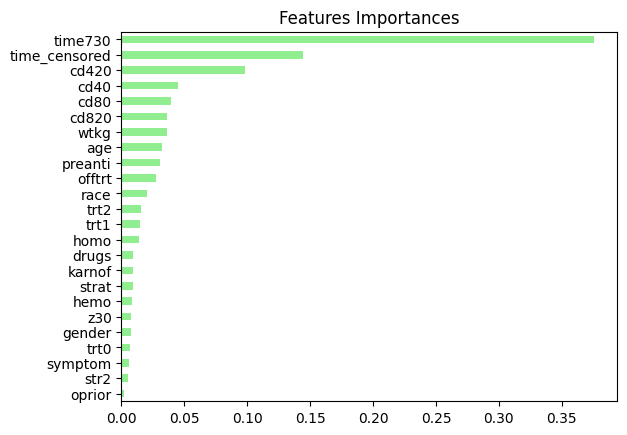

In [21]:
# Create a pd.Series of features importances
importances = pd.Series(data=model.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

## Hyperparameter optimization

### Set up GridSearchCV parameters

In [23]:
# Define the dictionary 'params_rf'
params_rf = {
            'n_estimators' : [100,350,500],
            'max_features' : ['log2','sqrt'],
            'min_samples_leaf' : [2,10,30]            
}

In [25]:
rf_classifier = RandomForestClassifier()

In [26]:
# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf_classifier,
                       param_grid=params_rf,
                       scoring='accuracy',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

### Fit GridSearchCV optimization 

In [27]:
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [100, 350, 500]},
             scoring='accuracy', verbose=1)

### Evaluate optimized RMFC 

In [28]:
# Extract the best estimator
best_model = grid_rf.best_estimator_

# Predict test set labels
y_pred = best_model.predict(X_test)


In [29]:

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print rmse_test
print('Test Accuracy of best model: {:.3f}'.format(accuracy))

Test Accuracy of best model: 0.897
